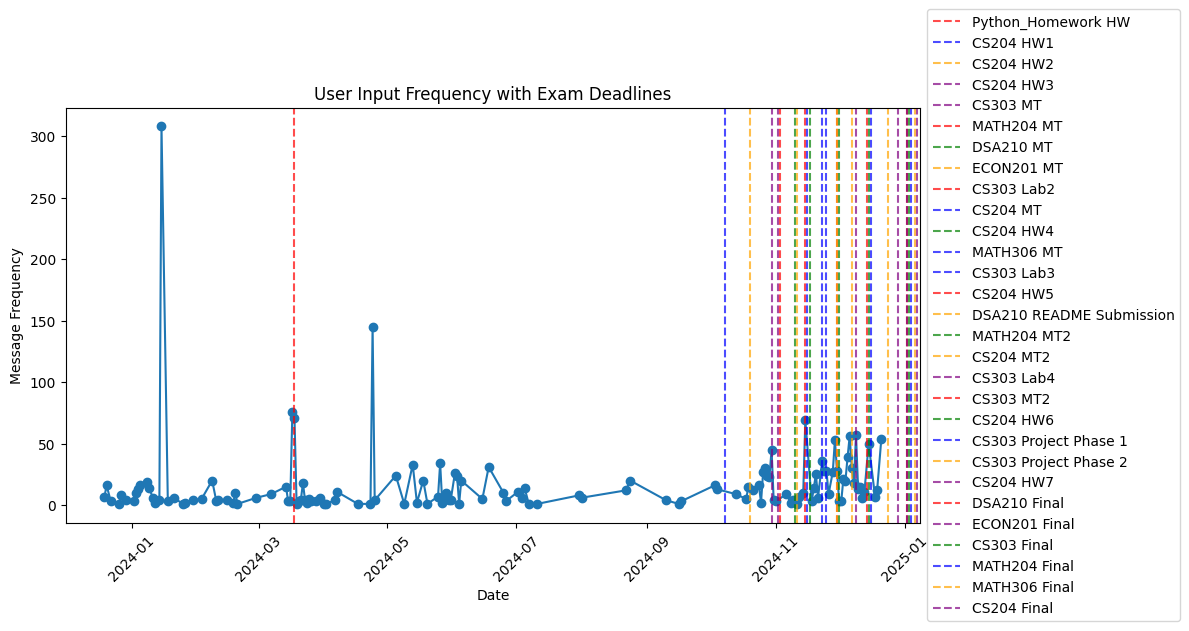

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Load CSV files with raw string paths
chat_history = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\consolidated_chat_history.csv')
exam_schedule = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\updated_exam_schedule.csv')

# Convert timestamp to datetime in chat history
chat_history['Timestamp'] = pd.to_datetime(chat_history['Timestamp'])

# Filter only user messages
user_messages = chat_history[chat_history['Sender'] == 'user']

# Start from the earliest chat entry
start_date = user_messages['Timestamp'].min().date()

# Group by date to get daily user input frequency
user_frequency = user_messages.groupby(user_messages['Timestamp'].dt.date).size()

# Convert exam date to datetime
exam_schedule['Date'] = pd.to_datetime(exam_schedule['Date'])

# Sort exam deadlines chronologically
exam_schedule = exam_schedule.sort_values(by='Date')

# Plot user input frequency
plt.figure(figsize=(12, 6))
plt.plot(user_frequency.index, user_frequency.values, marker='o', label='User Input Frequency')

# Plot exam deadlines as vertical lines with labels
colors = ['r', 'g', 'b', 'orange', 'purple']
handles = []
labels = []

for i, row in exam_schedule.iterrows():
    if row['Date'].date() >= start_date:
        line = plt.axvline(row['Date'], color=colors[i % len(colors)], linestyle='--', alpha=0.7)
        handles.append(line)
        labels.append(f"{row['Course']} {row['Exam Type']}")

# Sort legend by date
sorted_indices = sorted(range(len(labels)), key=lambda k: exam_schedule.iloc[k]['Date'])
sorted_handles = [handles[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

plt.legend(sorted_handles, sorted_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Date')
plt.ylabel('Message Frequency')
plt.title('User Input Frequency with Exam Deadlines')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





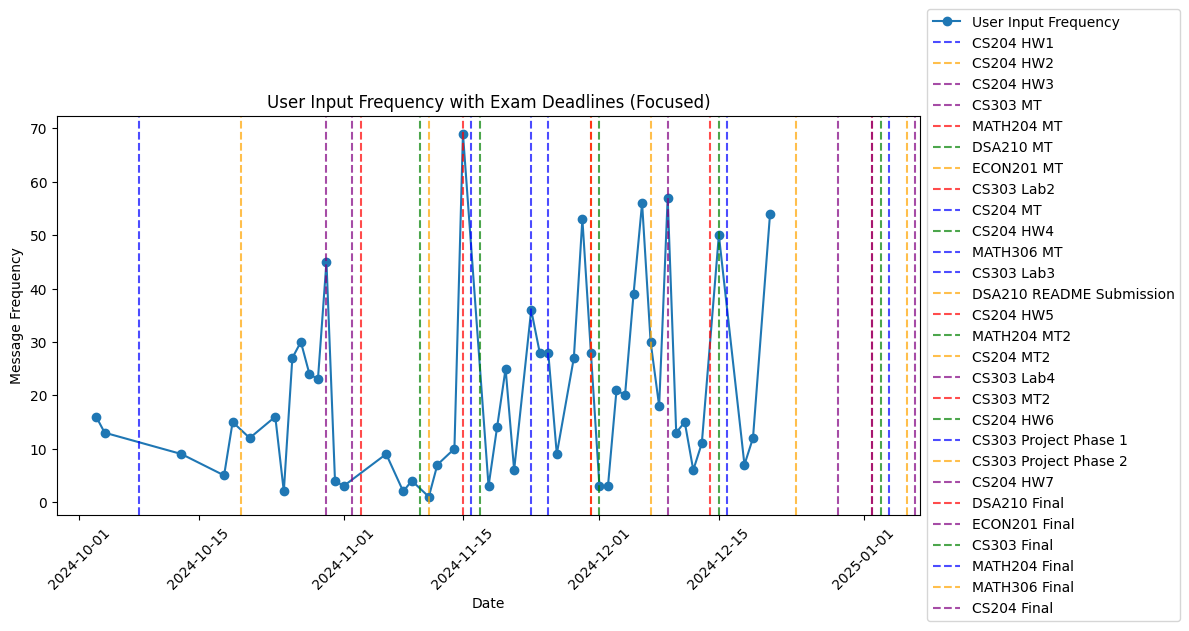

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Load CSV files with raw string paths
chat_history = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\consolidated_chat_history.csv')
exam_schedule = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\updated_exam_schedule.csv')

# Convert timestamp to datetime in chat history
chat_history['Timestamp'] = pd.to_datetime(chat_history['Timestamp'])

# Filter only user messages
user_messages = chat_history[chat_history['Sender'] == 'user']

# Start from the earliest chat entry
start_date = user_messages['Timestamp'].min().date()

# Group by date to get daily user input frequency
user_frequency = user_messages.groupby(user_messages['Timestamp'].dt.date).size()

# Convert exam date to datetime
exam_schedule['Date'] = pd.to_datetime(exam_schedule['Date'])

# Focus on the period starting from October 2024 to the present
focus_start_date = datetime(2024, 10, 1).date()
filtered_frequency = user_frequency[user_frequency.index >= focus_start_date]
filtered_exam_schedule = exam_schedule[exam_schedule['Date'].dt.date >= focus_start_date]

# Sort exam deadlines chronologically
filtered_exam_schedule = filtered_exam_schedule.sort_values(by='Date')

# Plot user input frequency
plt.figure(figsize=(12, 6))
plt.plot(filtered_frequency.index, filtered_frequency.values, marker='o', label='User Input Frequency')

# Plot exam deadlines as vertical lines with labels
colors = ['r', 'g', 'b', 'orange', 'purple']
for i, row in filtered_exam_schedule.iterrows():
    plt.axvline(row['Date'], color=colors[i % len(colors)], linestyle='--', alpha=0.7, 
                label=f"{row['Course']} {row['Exam Type']}")

plt.xlabel('Date')
plt.ylabel('Message Frequency')
plt.title('User Input Frequency with Exam Deadlines (Focused)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





Now lets check the correlation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

# Load CSV files with raw string paths
chat_history = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\consolidated_chat_history.csv')
exam_schedule = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\updated_exam_schedule.csv')

# Convert timestamp to datetime in chat history
chat_history['Timestamp'] = pd.to_datetime(chat_history['Timestamp'])

# Filter only user messages
user_messages = chat_history[chat_history['Sender'] == 'user']

# Group by date to get daily user input frequency
user_frequency = user_messages.groupby(user_messages['Timestamp'].dt.date).size().reset_index(name='MessageCount')
user_frequency['Date'] = pd.to_datetime(user_frequency['Timestamp'])

# Convert exam date to datetime
exam_schedule['Date'] = pd.to_datetime(exam_schedule['Date'])

# Sort exam deadlines chronologically
exam_schedule = exam_schedule.sort_values(by='Date').reset_index(drop=True)

# Function to find days until next exam for a given date
def days_until_next_exam(current_date, exam_dates):
    future_exams = exam_dates[exam_dates >= current_date]
    if not future_exams.empty:
        next_exam = future_exams.min()
        delta = (next_exam - current_date).days
        return delta
    else:
        return np.nan  # No upcoming exams

# Apply the function to each date in user_frequency
exam_dates = exam_schedule['Date'].dt.normalize()
user_frequency['DaysUntilExam'] = user_frequency['Date'].apply(lambda x: days_until_next_exam(x, exam_dates))

# Drop rows where DaysUntilExam is NaN (no upcoming exams)
filtered_data = user_frequency.dropna(subset=['DaysUntilExam'])

# Prepare data for regression
X = filtered_data[['DaysUntilExam']].values  # Independent variable
y = filtered_data['MessageCount'].values    # Dependent variable

# Initialize and fit the regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DaysUntilExam', y='MessageCount', data=filtered_data, color='blue', label='Data Points')

# Plot regression line
sns.regplot(x='DaysUntilExam', y='MessageCount', data=filtered_data, scatter=False, color='red', label='Regression Line')

plt.xlabel('Days Until Next Exam')
plt.ylabel('User Message Frequency')
plt.title('Correlation Between User Activity and Proximity to Exam Dates')
plt.legend()

# Annotate R-squared on the plot
plt.text(0.05, 0.95, f'$R^2$ = {r_squared:.2f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.tight_layout()
plt.show()

# Print R-squared
print(f'Coefficient of Determination (R²): {r_squared:.4f}')


ModuleNotFoundError: No module named 'sklearn'